In [76]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [77]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2484]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

In [79]:
import requests
import json
from datetime import datetime
import time

In [80]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2395]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 

### Import Custom Modules

In [672]:
from config import yelp_api_key
from config import darksky_api_key
from restaurant_info import Location
from weather import Weather

### Get Latitude & Longitude from Yelp API

In [2478]:
search_business = 'The Counting Room' # Not the actual Restaurant 
location = 'Brooklyn, NY'

In [2430]:
# Make Yelp API Call to get Latitude & Longitude for Business
rest_loc = Location(search_business, location)
lat, long = rest_loc.get_lat_long()

Weather Location: The Counting Room


### Darksky API Call

In [678]:
# Make Darksky API Call for Date Range as of specific time for given Latitude & Longitude
weather_call = Weather(lat, long,'19:30:00')
weather_df = weather_call.weather_df(start_date, end_date)

In [679]:
weather_df.to_csv(f'csv/weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'csv/weather_{start_date}_to_{end_date}.csv'

## Import / Clean / Prep File

In [2431]:
# Restaurant File
current_file = 'csv/rest_1_daily_sales.csv'

# Weather File
weather_csv_file = 'csv/weather_2017-01-01_to_2019-06-10.csv'

### Import Sales / Weather Data & Merge

In [2471]:
class importMerge:
    
    def __init__(self, sales_file, weather_file):
        self.sales_file = sales_file
        self.weather_file = weather_file
    
    def import_clean_merge(self):
        
        # Read in Sales File
        data = pd.read_csv(self.sales_file, index_col = 'date', parse_dates=True)
        df = pd.DataFrame(data)

        # Rename Column to 'sales'
        df = df.rename(columns={'net_sales': 'sales'})

        # Fill NaN
        df.fillna(0, inplace=True)

        # Filter to target dates
        df = df[(df.index > start_date) & (df.index < end_date)]

        # Import and clean weather file
        weather_df_csv = pd.read_csv(self.weather_file, parse_dates=True, index_col='date')
        weather_df_csv['summary'].fillna(value='none', inplace=True)

        # Merge sales and weather csv
        df = pd.merge(df, weather_df_csv, how='left', on='date')
        
        return df

### Transformer to Add Calendar Functions

In [2433]:
class CalendarTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, additional_closed_dates):
        self.additional_closed_dates = additional_closed_dates
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        cal = calendar()
        
        potential_closed_dates = X[X[target] == 0].index
        
        X['closed'] = np.where(( ( (X.index.isin(potential_closed_dates) ) & 
                              ( X.index.isin(cal.holidays(start_date, end_date ) ) )) | 
                                X.index.isin(self.additional_closed_dates)), 1, 0)
        
        X['sales'] = np.where(X['closed'] == 1, 0, X['sales'])
        
        # THREE DAY WEEKEND FEATURE
        sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
        X['sunday_three_day'] = np.where(X.index.isin(sunday_three_days), 1, 0)
        
        return X

### Transformer to Identify & Impute Outliers

In [2434]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, z_thresh):
        self.z_thresh = z_thresh
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
            
        for c in ['sales', 'covers']:

            count = 0

            for d in X['day_of_week'].unique():

                # Median / Mean / STD for each day of the week
                daily_median = np.median(X[X['day_of_week'] == d][c])
                daily_mean = np.mean(X[X['day_of_week'] == d][c])
                daily_std = np.std(X[X['day_of_week'] == d ][c])

                # Temporary column encoded if Target Columns have an Outlier
                X['temp_col'] = np.where((X['day_of_week'] == d) & 
                                         (X['closed'] == 0) & 
                                         ((np.abs(X[c] - daily_mean)) > (daily_std * self.z_thresh)), 1, 0)

                # Replace Outlier with Median
                count += np.sum(X['temp_col'])
                X[c] = np.where(X['temp_col'] == 1, daily_median, X[c])
                X.drop(['temp_col'], axis=1, inplace=True)

            print(f'Outliers imputed - {c}: {count} -> {(count / len(df)*100):.2f}% of total')
            
        return X

### Transformer to add Basic Features

In [2374]:
class BasicFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, month_clusters):
        self.month_clusters = month_clusters
        
    def fit(self, X, y = None):

        """ KMeans Month Clusters"""
    
        # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
        describe = X.groupby('month')[target].aggregate(['median', 'std', 'max'])
        temp_df = describe.reset_index()

        # SCALE TEMPORARY DF
        scaler = MinMaxScaler()
        f = scaler.fit_transform(temp_df)

        # INSTANTIATE MODEL
        km = KMeans(n_clusters=self.month_clusters, random_state=0).fit(f)

        # GET KMEANS CLUSTER PREDICTIONS
        labels = km.predict(f)

        # MAKE SERIES FROM PREDICTIONS
        temp_series = pd.DataFrame(labels, columns = ['cluster'], index=temp_df.index)

        # CONCAT CLUSTERS TO DATAFRAME
        temp_df = pd.concat([temp_df, temp_series], axis=1)

        # CREATE CLUSTER DICTIONARY
        temp_dict = {}
        for i in list(X['month']):
            temp_dict[i] = temp_df.loc[temp_df['month'] == i, 'cluster'].iloc[0]
            
        print('Month Clusters: ', temp_dict, '\n', 'Total Clusters: ', len(set(temp_dict.values())))
        
        # CREATE DICTIONARY TO BE ACCESSED IN TRANSFORM
        self.temp_dict = temp_dict
        
        return self
           
    def transform(self, X, y = None):
        
        ## ADD PER PERSON AVERAGE
        X['ppa'] = np.where(X['covers'] > 0, X['sales'] / X['covers'], 0)
        
        ## ADD MONTHLY CLUSTER FEATURE
        X['month_cluster'] = X['month'].apply(lambda x: self.temp_dict[x]).astype('category')
        X.drop(['month'], axis=1, inplace=True)
        
        
        # ADD DAY OF WEEK AND MONTH CLUSTER DUMMIES
        X['day_of_week'] = X['day_of_week'].astype('category')
        X = pd.get_dummies(data=X, columns=['day_of_week', 'month_cluster'])
        
        
        ## TREND FEATURE -> SHORT TERM MOVING AVERAGE OVER LONG TERM MOVING AVERAGE
        X['target_trend'] = X[target].shift(1).rolling(trend_days_rolling).mean() / \
                            X[target].shift(1 + trend_days_shift).rolling(trend_days_rolling).mean()
        
        return X

### Transformer to Apply Weather Features

In [2459]:
class WeatherFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, temp_bins, open_time, close_time):
        self.temp_bins = temp_bins
        self.open_time = open_time
        self.close_time = close_time
    
    def fit(self, X, y = None):
        return self
    
    def between_time(self, check_time):

        hs_dt = datetime.strptime(self.open_time, "%I:%M%p")
        he_dt = datetime.strptime(self.close_time, "%I:%M%p")

        if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:
            return 1
        else:
            return 0
    
    def transform(self, X, y = None):
        
        #FIT ONEHOT ENCODER
        temp_enc = KBinsDiscretizer(n_bins=self.temp_bins, encode='onehot', strategy='kmeans')
        temp_enc.fit(X[['apparent_temperature']])
    
        #BIN TEMPERATURES INTO CATEGORIES
        binned_transform = temp_enc.transform(X[['apparent_temperature']])
        binned_df = pd.DataFrame(binned_transform.toarray(), index=X.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot'])
        X = X.merge(binned_df, how='left', on='date')
        
        ## ADD POOR WEATHER FEATURE
        ## IF PRECIP INTENSITY MAX DURING SERVICE, THEN PRECIP WHILE OPEN EQUALS 1
        X['precip_while_open'] = np.where(X['precip_intensity_max'] > 0, X['precip_max_time'].apply(lambda x: self.between_time(x)), 0)
        
        ## DROP UNNECESSARY COLUMNS
        X.drop(['apparent_temperature', 'temperature', 'precip_intensity_max', 'precip_max_time', 'summary', 'precip_type', 'pressure'], axis=1, inplace=True)

        return X

### Transformer to Apply Interactions

In [2460]:
class InteractionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X['outside_X_precip_open'] = X['outside'] * X['precip_while_open']
            
        for t in [col for col in X.columns if col.startswith('temp_')]:

            col_name = t + '_X_' + 'outside'
            X[col_name] = X[t] * X['outside']

        X.drop(['outside', 'day_of_week_0'], axis=1, inplace=True)
    
        if X.columns.any() in target_list:
        
            target_to_drop = [t for t in target_list if t != target]
            X.drop(target_to_drop, axis=1, inplace=True)
            
        return X

###  Set Up - Variables

In [2553]:
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-10' # End Date Exclusive

target_list = ['sales', 'ppa', 'covers']
target = 'sales'

# Temperature Bins
temp_bins = 4

# Month Clusters
month_clusters = 3

# Outlier Threshold
z_thresh = 2

# Time Range for "Precipitation While Open" Feature
open_time = '05:00PM'
close_time = '11:59PM'

# Windows for Moving Average
trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

# Test / Train / Split
train_date_start = '2017-01-01'
train_date_end = '2018-12-31'

### Pipeline Set Up

In [2554]:
pre_pipe = Pipeline ( steps = [ ( 'closed' , CalendarTransformer(additional_closed_dates) ),
                                ( 'outliers', OutlierTransformer(z_thresh) ) ] )

post_pipe = Pipeline (steps = [ ( 'basic_features', BasicFeatureTransformer(month_clusters) ),
                                ( 'weather_features', WeatherFeatureTransformer(temp_bins, open_time, close_time) ),
                                ( 'interactions', InteractionTransformer() ) ] )

### Correlation Matrix Helper Function

In [2546]:
def corr_chart(df):
    
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    

### Train / Test / Split Helper Functions

In [2547]:
def drop_target(df):
    
    y = df[target][days_fwd:]
    features = df.drop([target], axis=1)[days_fwd:]

    return features, y

In [2548]:
def train_test_split(X, y, train_date_start, train_date_end):
    
    X_train = X[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = X[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    X_train = pd.DataFrame(X_train, columns=X_train.columns)
    X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    print(f'Train set: {len(X_train)} -> {len(X_train) / len(df)*100:.2f}%')
    print(f'Train set: {len(X_test)} -> {len(X_test) / len(df)*100:.2f}%')
    
    return X_train, X_test, y_train, y_test

### Scoring Helper Function

In [2549]:
def model_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    print('----------------', '\n')
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Calculated Scores:', '\n', 'Test R-Squared: ', r_squared,'\n', 'Test Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=5, scoring='r2')), '\n')
    
    try:
        print('Intercept:  ', rgr.intercept_, '\n')
        print('Coefficients:  \n')

        for index, col_name in enumerate(X_test.columns):
            print(col_name, ' --> ', rgr.coef_[index])
    except:
        pass
        
    return pred_df

### Feature Importance - Helper Function

In [2550]:
def feature_importance(rgr, X_train, y_train):
    
    features = list(X_train.columns)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()

    labels = list(map(lambda x: x.title(), features))
    visualizer = FeatureImportances(rgr, ax=ax, labels=labels, relative=False)

    visualizer.fit(X_train, y_train)
    visualizer.poof();

### Residual Plot - Helper Function

In [2551]:
def residual_plot(rgr, X_train, y_train, X_test, y_test):

    plt.figure(figsize=(12,8))

    visualizer = ResidualsPlot(rgr, hist=False)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof();

## Linear Regression "Pipeline"

Outliers imputed - sales: 13 -> 1.46% of total
Outliers imputed - covers: 11 -> 1.24% of total
Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  3
Train set: 693 -> 77.95%
Train set: 160 -> 18.00%
---------------- 

Calculated Scores: 
 Test R-Squared:  0.8356465984778212 
 Test Adjusted R-Squared:  0.8064282159849894 

Train R-Squared:   0.79311963272172
Test R-Squared:   0.8356465984778211 

Root Mean Squared Error:  1247.334687626455 

Cross Val Avg R-Squared:  0.7575238253142436 

Intercept:   9851.631062187338 

Coefficients:  

humidity  -->  -1478.3585668213025
precip_prob  -->  -109.40571274798621
closed  -->  -14274.93928711618
sunday_three_day  -->  1447.3882430673627
day_of_week_1  -->  -84.99823582821143
day_of_week_2  -->  400.2951952520465
day_of_week_3  -->  1065.3035438646416
day_of_week_4  -->  2535.7362261291278
day_of_week_5  -->  3681.676573563533
day_of_week_6  -->  1032.256736473325
month_cluster_0  -->

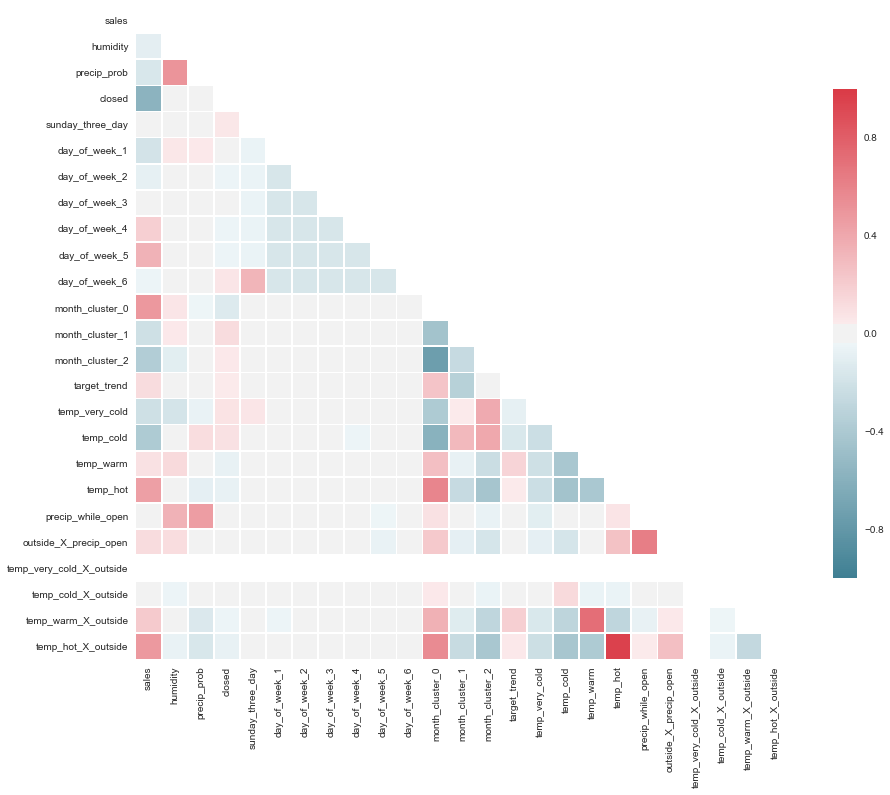

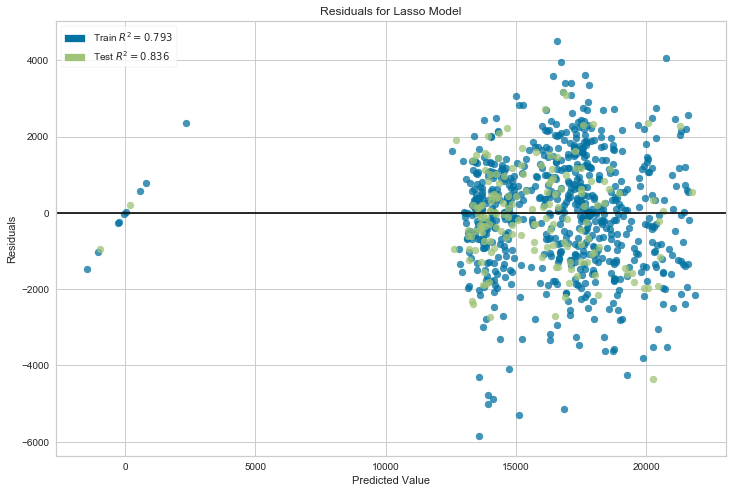

In [2556]:
def run_linear(current_file, weather_csv_file, pre_pipe, post_pipe):

    # Import & Merge Weather & Sales CSV Files
    obj = importMerge(current_file, weather_csv_file)
    df = obj.import_clean_merge()
    
    # Pre Processing Pipeline
    df = pre_pipe.fit_transform(df)
    
    # Feature Engineering Pipeline
    df = post_pipe.fit_transform(df)
    
    # Separate Target & Features
    X, y = drop_target(df)
    
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_date_start, train_date_end)
    
    # Fit a Lasso Regression Model
    lassoReg = Lasso(fit_intercept=True, alpha=1)
    lasso_rgr = lassoReg.fit(X_train,y_train)
    
    # Run Regression Scoring Helper Function
    pred_df = model_score(lasso_rgr, X_train, y_train, X_test, y_test, X, y)
    
    # Get Correlation Matrix
    corr_chart(df)
    
    # Residual Chart
    residual_plot(lasso_rgr, X_train, y_train, X_test, y_test)
    
    return pred_df, y_test, X_train
    
pred_df, y_test, X_train = run_linear(current_file, weather_csv_file, pre_pipe, post_pipe)

## Run XGB Regressor "Pipeline"

Outliers imputed - sales: 13 -> 1.46% of total
Outliers imputed - covers: 11 -> 1.24% of total
Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  3
Train set: 693 -> 77.95%
Train set: 160 -> 18.00%
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   30.0s finished


Grid Search:  XGBRegressor 

Grid Search Best Score:  -2696428.2434873558
Grid Search Best Params:  {'colsample_bytree': 0.925, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'min_impurity_decrease': 0.0001, 'n_estimators': 325}
Grid Search Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.925, gamma=0, importance_type='gain',
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=2, min_impurity_decrease=0.0001, missing=None,
       n_estimators=325, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
---------------- 

Calculated Scores: 
 Test R-Squared:  0.8410553320729708 
 Test Adjusted R-Squared:  0.8127985022192767 

Train R-Squared:   0.8242836492665017
Test R-Squared:   0.8410553320729707 

Root Mean Squared Error:  1226.6386176119142 

Cross Val Avg R-Squared:  0.75

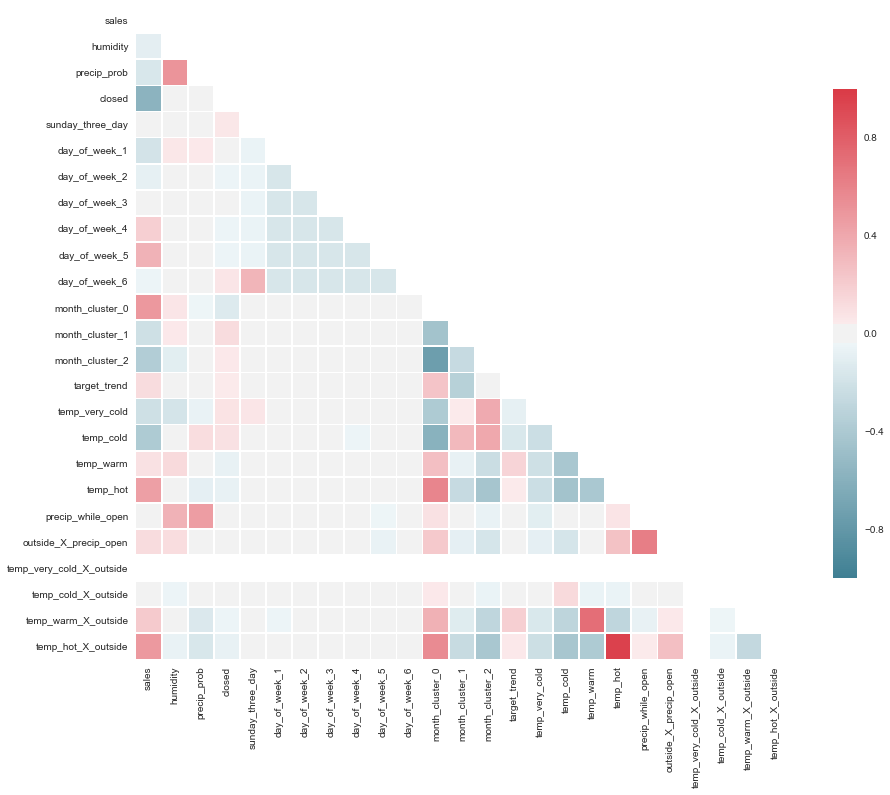

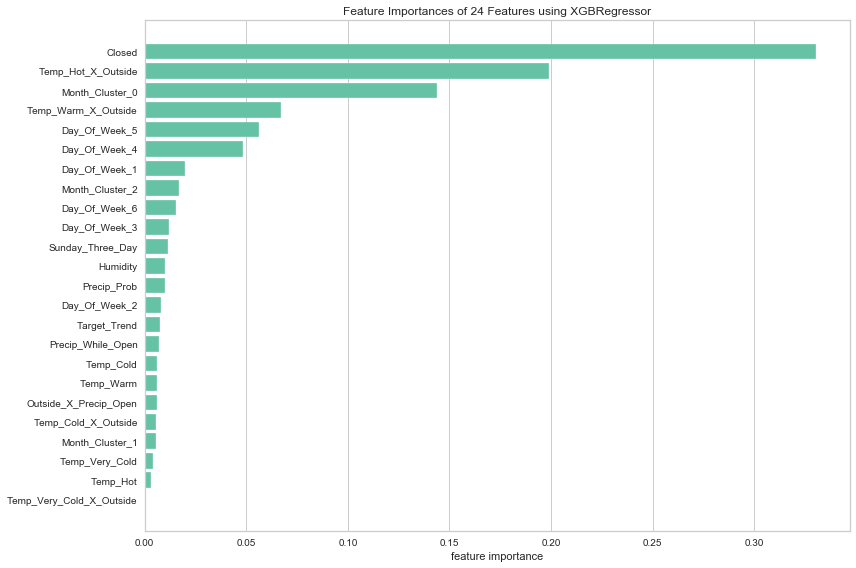

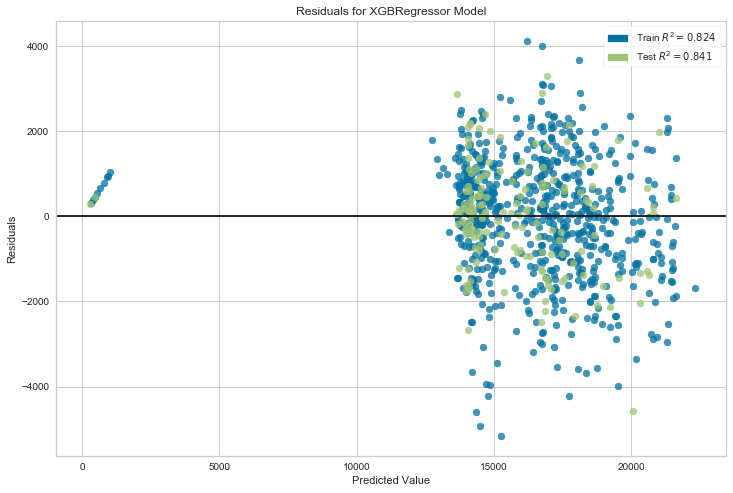

In [2557]:
params = {
          'learning_rate': [0.0175, 0.020],
          'max_depth': [3, 4],
          'min_impurity_decrease': [0.0001, 0.00015],
          'colsample_bytree': [0.90, 0.925],
          'n_estimators': [300, 325],
          'min_child_weight': [2]
        }

def run_xgb(current_file, weather_csv_file, pre_pipe, post_pipe, params):
    
    # Import & Merge Weather & Sales CSV Files
    obj = importMerge(current_file, weather_csv_file)
    df = obj.import_clean_merge()

    # Pre Processing Pipeline
    df = pre_pipe.fit_transform(df)
    
    # Feature Engineering Pipeline
    df = post_pipe.fit_transform(df)
    
    # Separate Target & Features
    X, y = drop_target(df)
    
    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_date_start, train_date_end)

    # Instantiate XGB Regressor object
    rgr = XGBRegressor(booster='gbtree', objective='reg:linear', random_state = 0)
    
    # Scoring attribute for Grid Search
    scoring = 'neg_mean_squared_error'
    
    # Instantiate & Fit Grid Search Object
    grid = GridSearchCV(rgr, params, cv=5, n_jobs=-1, scoring=scoring, verbose=5)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)
    
    # Run Regression Scoring Helper Function
    pred_df = model_score(best_grid_rgr, X_train, y_train, X_test, y_test, X, y)
    
    # Get Correlation Matrix
    corr_chart(df)
    
    # Feature Importance Chart
    feature_importance(best_grid_rgr, X_train, y_train)
    
    # Residual Chart
    residual_plot(best_grid_rgr, X_train, y_train, X_test, y_test)
    
    return pred_df, y_test, best_grid_rgr, X_train

pred_df, y_test, best_grid_rgr, X_train = run_xgb(current_file, weather_csv_file, pre_pipe, post_pipe, params)

## Evaluation - Actual Sales vs. Predicted

In [2573]:
obj = importMerge(current_file, weather_csv_file)
data = obj.import_clean_merge()

data = data.rename(columns={'sales': 'true_sales'})
pred_df = pred_df.rename(columns={'sales': 'pred_sales'})

eval_df = pred_df.merge(data, on='date', how='inner')

eval_df['mape'] = np.where(eval_df['true_sales'] > 0, np.abs(eval_df['true_sales'] - eval_df['pred_sales']) / eval_df['true_sales'], 0)
eval_df['absolute_error'] = np.abs(eval_df['true_sales'] - eval_df['pred_sales'])

print('Mean Absolute Error by Day:')
eval_df.groupby('day_of_week')['absolute_error'].aggregate(['mean', 'std'])

print(f'Mean Absolute Error: ${eval_df.absolute_error.sum() / len(eval_df.absolute_error):.2f}', '\n')

print(f'Mean Absolute Error Percentage: {eval_df.mape.mean() * 100:.2f}%', '\n')

print('--------', '\n', 'Highest Absolute Errors by Day:')
eval_df.loc[eval_df.groupby(['day_of_week'])['mape'].idxmax()][['pred_sales', 'true_sales', 'outside', 'day_of_week', 'mape', 'absolute_error']]


Mean Absolute Error by Day:


,mean,std
day_of_week,,
0,918.800236,735.666880
1,774.859062,925.944232
2,1879.707451,2690.708330
3,680.835268,475.881905
4,1038.609419,1045.505299
5,1736.313512,2068.499754
6,886.733551,780.100399


Mean Absolute Error: $1132.16 

Mean Absolute Error Percentage: 6.60% 

-------- 
 Highest Absolute Errors by Day:


,pred_sales,true_sales,outside,day_of_week,mape,absolute_error
date,,,,,,
2019-01-21,14140.378906,11967.25,0,0,0.181590,2173.128906
2019-01-08,13670.581055,10811.32,0,1,0.264469,2859.261055
2019-02-27,14125.103516,27909.75,0,2,0.493901,13784.646484
2019-04-18,17077.445312,18789.73,1,3,0.091129,1712.284688
2019-05-10,19512.613281,24313.54,1,4,0.197459,4800.926719
2019-01-26,17581.447266,25000.00,0,5,0.296742,7418.552734
2019-05-12,14665.689453,12262.59,0,6,0.195970,2403.099453


### Run Final Model on Entire Dataset

## Predictions

In [2574]:
outside = 0

def predict_one(rgr, X_train, y_test, end_date):

    date_1 = pd.to_datetime(end_date) + pd.DateOffset(-days_fwd)
    date_2 = end_date
     
    # Pull Weather Data / Forecast
    weather_df = rest_weather.weather_df(date_1, date_2)
    weather_df['outside'] = outside
    weather_df['covers'] = 1
    
    # Add Sales Data for Sales Trend Engineering
    df = pd.merge(weather_df, y_test, on='date', how='left')
    
    # Add Feature Engineering
    df = post_pipe.transform(df)
    
    #df = target_trend_engineering(df)
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-1:]
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(rgr.predict(df), index=df.index, columns=[target])
    pred_df = pred_array.merge(df, on='date', how='left')
    
    return pred_df

In [2575]:
predict_date = '2019-06-10'

tonight = predict_one(best_grid_rgr, X_train, y_test, predict_date)
tonight

,sales,humidity,precip_prob,closed,sunday_three_day,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,temp_very_cold,temp_cold,temp_warm,temp_hot,precip_while_open,outside_X_precip_open,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside
date,,,,,,,,,,,,,,,,,,,,,
2019-06-10,14470.266602,0.97,0.0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,0.0


### Predict Upcoming Week

In [133]:
def predict_multiple(rgr, df, start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    temp_df = df
    
    for day in list_of_days:
        
        temp_df = pd.concat([temp_df, predict_one(rgr, temp_df, day)], axis=0)
    
    return temp_df

upcoming_df = predict_multiple(xgb_rgr_finalized, dfx, '2019-06-10', '2019-06-17')

In [134]:
upcoming_df[-7:][[target, 'closed', 'humidity', 'precip_prob', 'precip_while_open', 'outside_X_precip_open', 'target_trend']]

,sales,closed,humidity,precip_prob,precip_while_open,outside_X_precip_open,target_trend
date,,,,,,,
2019-06-19,14610.288086,0,0.95,0.00,1,0.0,0.976882
2019-06-20,14096.017578,0,0.86,0.21,0,0.0,0.977449
2019-06-21,17220.195312,0,0.49,0.01,0,0.0,0.976745
2019-06-22,18292.398438,0,0.40,0.00,1,0.0,0.974877
2019-06-23,14665.337891,0,0.37,0.00,0,0.0,0.973045
2019-06-24,14718.222656,0,0.71,0.07,1,0.0,0.958175
2019-06-25,13878.599609,0,0.68,0.01,0,0.0,0.959670


In [135]:
np.sum(upcoming_df[-7:][target])

107481.0595703125

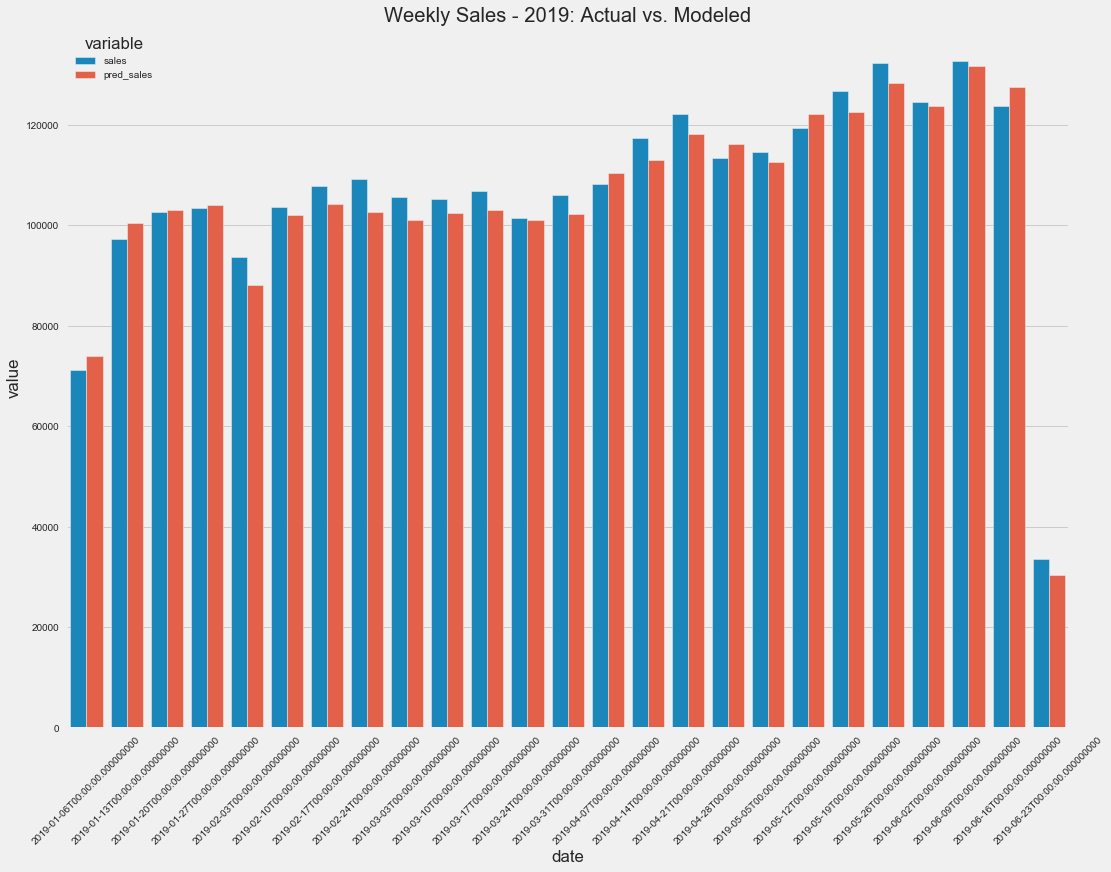

In [125]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(16,12))

eval_df_weekly = eval_df[['sales', 'pred_sales']]['2019'].resample('W').sum()
ew = pd.melt(eval_df_weekly.reset_index(), id_vars='date')

sns.barplot(x = 'date', y = 'value', hue = 'variable', data = ew)

plt.title('Weekly Sales - 2019: Actual vs. Modeled')
plt.xticks(rotation=45)

plt.show();